In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras
from tf_keras.layers import Dense, Dropout

import datetime

import matplotlib.pyplot as plt

tfd = tfp.distributions

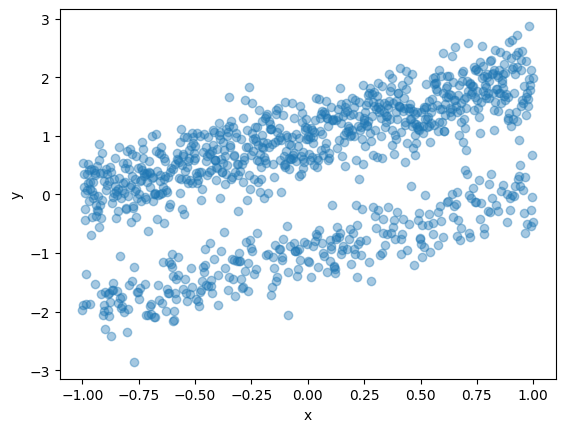

In [3]:
X_train = np.linspace(-1, 1, 1000)[:, np.newaxis]

n_samples = 1000

selectors = np.random.choice([0, 1], size=n_samples, p=[0.3,0.7])
noise1 = np.random.normal(-1, 0.3, n_samples)
noise2 = np.random.normal(1, 0.4, n_samples)
mixture_noise = np.where(selectors == 0, noise1, noise2)
mixture_noise = mixture_noise[:, np.newaxis]
y_train = X_train + mixture_noise

plt.scatter(X_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
%load_ext tensorboard

In [5]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

model = tf_keras.Sequential([Dense(64, kernel_initializer='he_normal', activation='relu', input_shape=(1,)),
                             Dense(64, kernel_initializer='he_normal', activation='relu'),
                             Dense(64, kernel_initializer='he_normal', activation='relu'),
                             Dense(6),
                             tfp.layers.DistributionLambda(lambda t: tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=t[...,:2] / 0.1),
                                                                                            components_distribution=tfd.Normal(loc=t[...,2:4],
                                                                                                                               scale=1e-3 + tf.nn.softplus(t[..., 4:6]))))],
                            name = "double_gaussian_output")

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.0001), loss=negloglik)

history = model.fit(X_train, y_train, batch_size=32,
                    epochs=20, verbose=0, callbacks=tf_keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))

2025-07-15 13:55:32.358805: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2025-07-15 13:55:32.358830: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-07-15 13:55:32.358834: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: borsuk
2025-07-15 13:55:32.358836: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: borsuk
2025-07-15 13:55:32.358927: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 570.133.7
2025-07-15 13:55:32.358947: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 5

In [6]:
%tensorboard --logdir logs/fit

In [18]:
# y_sample = y_model.sample()
# y_hat = y_model.mean()
# y_std = y_model.stddev()

# y_hat_m2std = y_hat - 2 * y_std
# y_hat_p2std = y_hat + 2 * y_std

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# ax1.scatter(X_train, y_train, alpha=0.4, label='data')
# ax1.scatter(X_train, y_sample, alpha=0.4, color='red', label='model sample')
# ax1.legend(loc='best')

# ax2.scatter(X_train, y_train, alpha=0.4, label='data')
# ax2.plot(X_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
# ax2.plot(X_train, y_hat_m2std, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
# ax2.plot(X_train, y_hat_p2std, color='green', alpha=0.8)
# ax2.legend(loc='best')
# plt.show()

tf.Tensor([0.32971928], shape=(1,), dtype=float32)


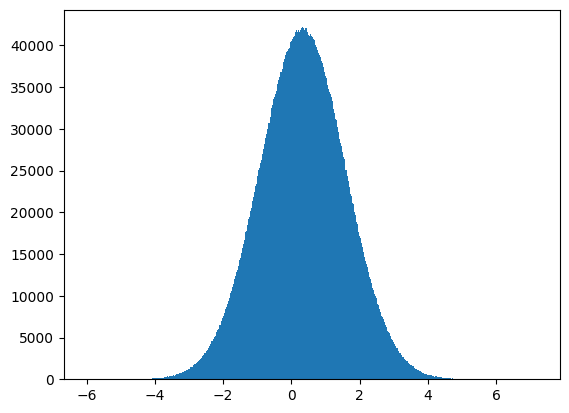

In [21]:
x = 1
y_model = model(X_train[x:x+1])
y_pred = y_model.sample(10000000).numpy()
print(y_model.mean())
plt.hist(y_pred, bins=1000)
plt.show()

In [20]:
y_train[363]

array([0.83020754])

In [22]:
means = y_model.components_distribution.loc.numpy()
stds = y_model.components_distribution.scale.numpy() 
means, stds

(array([[-0.47939694,  0.32971928]], dtype=float32),
 array([[0.63785255, 1.2550447 ]], dtype=float32))